# Transfer Learning using EfficientNetB4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
%matplotlib inline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
data_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir =pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
fire = list(data_dir.glob('fire/*'))
img = PIL.Image.open(str(fire[0]))
display(img)

### Load data into a tf dataset

Image input size: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [ ]:
batch_size = 32
img_height = 224
img_width = 224
# Validation split 80/20
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               validation_split = 0.2,
                                                               subset = "training",
                                                               shuffle = True,
                                                               seed = 123,
                                                               image_size = (img_height, img_width),
                                                               batch_size = batch_size
                                                              )

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                             validation_split = 0.2,
                                                             subset = "validation",
                                                             shuffle = True,
                                                             seed = 123,
                                                             image_size = (img_height, img_width), 
                                                             batch_size = batch_size
                                                            )

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,
                                                              seed = 123,
                                                              image_size = (img_height, img_width),    
                                                              batch_size = batch_size
                                                             )

### Get Class Names

In [ ]:
class_names = train_ds.class_names
print(class_names)

### Visualise Data

In [ ]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)


### Create the base model from pre-trained convnets

In [ ]:
## By specifying "include_top=False" argument you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.EfficientNetB4(include_top=False,
                                                  weights="imagenet",
                                                  input_shape=IMG_SHAPE,
                                                  classifier_activation="softmax"
                                                 )
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

## Feature Extraction

In [ ]:
base_model.trainable = False
base_model.summary()

## Add classification head

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

### Chain together the model

In [ ]:
inputs = tf.keras.Input(shape = (IMG_SHAPE))
x = base_model(inputs, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [ ]:
# Useful metrics paper:# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=(True)),
              metrics = [tf.keras.metrics.Precision(name = "precision"),
                         tf.keras.metrics.Recall(name = "recall"),
                         tf.keras.metrics.AUC(name = "auc")] 
             )

In [ ]:
model.summary()

## Train the model

In [ ]:
# Tests the initial base model
initial_epochs = 10
loss0, precision0, recall0, auc0 = model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial precision: {:.2f}".format(precision0))
print("initial recall: {:.2f}".format(recall0))
print("initial auc: {:.2f}".format(auc0))

In [ ]:
history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

### Learning Curves

In [ ]:
recall = history.history['recall']
val_recall = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

precision = history.history['precision']
val_pre = history.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')
plt.subplot(4, 2, 4)

plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0,1.0])
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()


## Fine Tuning

In [ ]:
# Previously the base model weights were not updated and only a few layers on top of the EfficientNetB4 was trained
# Unfreeze and train the top layers of the pre-trained model to fine tune to the dataset

## Un-freeze top layers of the model
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 250

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Compile the Model

In [ ]:
## Important to use a lower training weight since using more layers, otherwise
# it could overfit very quickly 
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              metrics = [tf.keras.metrics.Precision(name = "precision"),
                         tf.keras.metrics.Recall(name = "recall"),
                         tf.keras.metrics.AUC(name = "auc")
                        ]
             )

model.summary()

In [ ]:
print(len(model.trainable_variables))

### Continue Training the Model

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds
                        )

### Learning Curves

In [ ]:
recall += history_fine.history['recall']
val_recall += history_fine.history['val_recall']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

auc += history_fine.history['auc']
val_auc += history_fine.history['val_auc']

precision += history_fine.history['precision']
val_pre += history_fine.history['val_precision']

plt.figure(figsize = (16, 16))
plt.subplot(4, 2, 1)
plt.plot(recall, label = 'Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Recall')

plt.subplot(4, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(4, 2, 3)
plt.plot(auc, label = 'Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation AUC')
plt.xlabel('epoch')

plt.subplot(4, 2, 4)
plt.plot(precision, label = 'Training Precision')
plt.plot(val_pre, label='Validation Precision')
plt.legend(loc='upper right')
plt.ylabel('Precision')
plt.ylim([0.7,1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Training and Validation Precision')
plt.xlabel('epoch')
plt.show()




In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,
                                                              seed = 123,
                                                              image_size = (img_height, img_width),
                                                              batch_size = batch_size
                                                             )
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)

## Verifying on test set

In [ ]:
loss, precision, recall, auc = model.evaluate(test_ds)
print('Test loss :', loss)
print('Test precision :', precision)
print('Test recall :', recall)
print('Test auc :', auc)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
#label = 

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

In [ ]:
print(np.round(predictions, 3))

In [ ]:
predictions = tf.where(predictions < 0.5, 0, 1)
print(predictions)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
# pred = model.predict(test_ds)
# pred = np.argmax(pred, axis = 1)[:5]
# label = 
# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)

predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:', predictions.numpy())
print('Labels:', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

## Saving model

In [ ]:
model.save('model00_EfficientNetB4.h5')

## Confusion Matrix

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import functions

data_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Training and Validation')
test_dir = pathlib.Path('/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Testing')
loaded_model = tf.keras.models.load_model('models/model00_EfficientNetB4.h5')
img_height, img_width, batch_size = [224, 224, 32]
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              shuffle = True,
                                                              seed = 89787,
                                                              image_size = (img_height, img_width),    
                                                              batch_size = batch_size,
                                                              labels = 'inferred',
                                                              label_mode = 'binary')



In [ ]:
confusion_matrix, cm = functions.ConfusionMatrix(loaded_model, 
                                             test_ds, 
                                             save_fig = True, 
                                             save_fig_location = "/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/CM_NO_IA_1_EfficientNetB4.svg")

In [ ]:
functions.CreateMetricsReport(model = loaded_model,
                             dataset = test_ds,
                             confusion_matrix = confusion_matrix)

## Testing on custom images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
import functions

loaded_model = tf.keras.models.load_model('models/model00_EfficientNetB4.h5')
input_shape = (224, 224)
img_directory = '/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/data/Photos-001/'

test_preds = functions.TestImages(img_directory, input_shape, loaded_model)


In [ ]:
count = 0
for i in test_preds:
    if i>0.5:
        print("no fire")
    else:
        count += 1
        print("fire")
print('Incorrectly predicted ', count,  ' out of ',len(test_preds), '. FPR: ', round(count/len(test_preds), 2))

## Testing on other dataset

In [1]:
import tensorflow as tf
import functions

data_dir = '../../data/Alt_dataset/Training Dataset'
loaded_model = tf.keras.models.load_model('models/model00_EfficientNetB4.h5')

img_height, img_width, batch_size = [224, 224, 32] 


custom_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    seed = 89787,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    labels = 'inferred',
    label_mode = 'binary'
    )

## Check if images are in the right format

bad_file_list = functions.CheckImagesReport(data_dir)

2022-04-26 10:38:14.271334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 10:38:14.271351: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-26 10:38:17.076980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:38:17.077159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/charlie/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-04-26 10:38:17.077216: W tensorflow/stream_executor/platform/default/

Found 2204 files belonging to 2 classes.
processing class directory  NoFire
processing class directory  Fire
 no improper image files were found


In [2]:
## Delete the incompatible files from the folder
if bad_file_list:
    functions.DeleteIncompatibleImages(bad_file_list)
else:
    print("No incompatible files")


No incompatible files


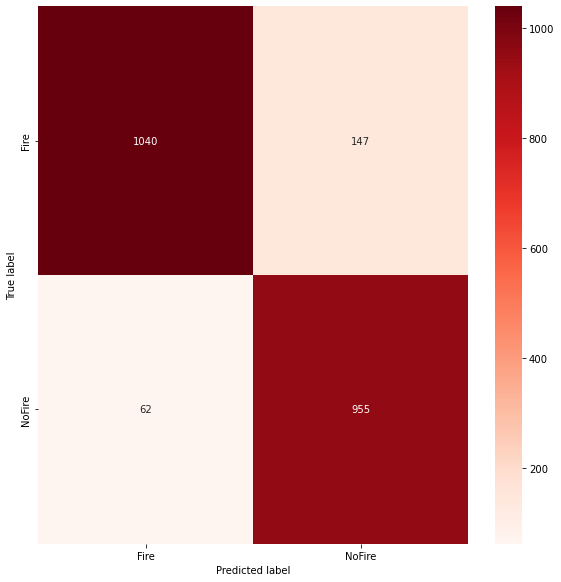

figure has been saved to: /home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/CM_NO_IA_2_EfficientNetB4.svg


In [3]:
confusion_matrix, cm = functions.ConfusionMatrix(loaded_model, 
                                             custom_test_ds, 
                                             save_fig = True, 
                                             save_fig_location = "/home/charlie/Documents/Uni/Exeter - Data Science/MTHM602_Trends_in_data_science_and_AI/Project/plots/EfficientNetB4/CM_NO_IA_2_EfficientNetB4.svg")

In [ ]:
functions.CreateMetricsReport(model = loaded_model,
                             dataset = custom_test_ds,
                             confusion_matrix = confusion_matrix)